In [1]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import pylab as pl
from sys import stdout
from time import time
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from tick.survival import CoxRegression
from tick.prox import ProxTV
from binacox import compute_score, multiple_testing, p_value_cut, get_groups
from lifelines.utils import concordance_index
from prettytable import PrettyTable
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
cancers = ["GBM", "KIRC", "BRCA"]
data = {}
for cancer in cancers:
    inputdir = "./data/%s/rna/" % cancer
    X = pd.read_csv(inputdir + 'X.csv')
    X = X.fillna(X.mean())
    Y = np.ravel(pd.read_csv(inputdir + 'T.csv')) + 1
    delta = np.ravel(pd.read_csv(inputdir + 'delta.csv'))
    data[cancer] = {"X": X, "Y": Y, "delta": delta}
    print("%s loaded: n=%s, p=%s" % (cancer, X.shape[0], X.shape[1]))

GBM loaded: n=168, p=20531
KIRC loaded: n=605, p=20531
BRCA loaded: n=1211, p=20531


### Screening

In [3]:
run_screening = False
screening_markers = {}
if run_screening:
    for cancer in cancers:
        X = data[cancer]["X"]
        Y = data[cancer]["Y"]
        delta = data[cancer]["delta"]
        n_features = X.shape[1]
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        n_cuts = 50
        binarizer = FeaturesBinarizer(n_cuts=n_cuts)
        screening_marker = pd.Series(index=X.columns)
        prox_tv = ProxTV(1)
        for j in range(n_features):
            stdout.write("\r%s screening: %d/%s" % (cancer, j + 1, n_features))
            stdout.flush()
            X_j = np.atleast_2d(X.ix[:, j]).T
            X_bin_j = binarizer.fit_transform(np.array(X_j))
            blocks_start = binarizer.blocks_start
            blocks_length = binarizer.blocks_length
            solver = 'agd'
            learner = CoxRegression(penalty='binarsity', tol=1e-5,
                                    solver=solver, verbose=False, 
                                    max_iter=100, step=0.3,
                                    blocks_start=blocks_start,
                                    blocks_length=blocks_length,
                                    warm_start=True, C=25)
            learner._solver_obj.linesearch = False
            learner.fit(X_bin_j, Y, delta)
            coeffs = learner.coeffs
            screening_marker[X.columns[j]] = prox_tv.value(learner.coeffs)
        screening_marker.to_csv('./screening/screening_marker_%s' % cancer)
        screening_markers[cancer] = screening_marker

Screen the top 50 features using TV norm on univariate Binacox model.


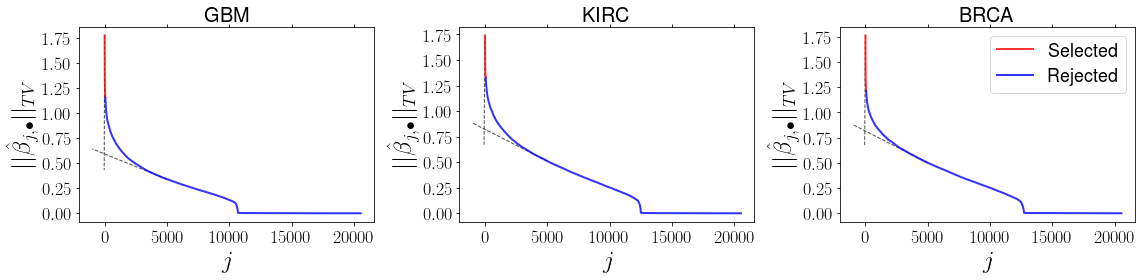

In [4]:
# number of selected features
p = 50
print("Screen the top %s features using TV norm on univariate Binacox model." % p)
Y_3_s = {"GBM":.43, "KIRC":.67, "BRCA":.67}
fig = pl.figure(figsize=(16, 4))
for i, cancer in enumerate(cancers):
    ax = fig.add_subplot(1, 3, i + 1)
    screening_marker = pd.read_csv('./screening/screening_marker_%s' % cancer, header=None, index_col=0)
    n_features = screening_marker.size
    screening_marker = screening_marker.sort_values(by=1, ascending=False)
    lw = 2
    alpha = .8
    label = ""
    if i == 2:
        label = 'Selected'
    ax.plot(range(p), screening_marker[:p], 'r', 
            lw=lw, alpha=alpha, label=label)
    if i == 2:
        label = 'Rejected'
    ax.plot(range(p, n_features), screening_marker[p:], 
            'b', lw=lw, alpha=alpha, label=label)
    if i == 2:
        pl.legend(fontsize=18) 
    pl.xlabel(r'$j$', fontsize=25)
    pl.ylabel(r'$||\hat\beta_{j, \bullet}||_{TV}$', fontsize=25)
    pl.tick_params(axis='x', which='both', top='off')
    pl.xticks(fontsize = 18)
    pl.yticks(fontsize = 18)
    pl.title(cancer, fontsize=20)

    x_1_s, y_1_s = 0, screening_marker.values[0]
    x_2_s, y_2_s = p - 1, screening_marker.values[p - 1]
    y_3_s = Y_3_s[cancer]
    x_1_r, y_1_r = 5000, screening_marker.values[5000]
    x_2_r, y_2_r = 4000, screening_marker.values[4000]
    x_3_r = -1000
    
    alpha = .7
    lw = 1
    a_r = (y_1_r - y_2_r) / (x_1_r - x_2_r)
    pl.plot([x_1_r, x_3_r], 
            [y_1_r, a_r * x_3_r + y_1_r - x_1_r * a_r], 
            'k--', lw=lw, alpha=alpha, zorder=0)
    a_s = (y_1_s - y_2_s) / (x_1_s - x_2_s)
    pl.plot([x_1_s, y_3_s / a_s - y_1_s - x_1_s * a_s], 
            [y_1_s, y_3_s], 'k--', lw=lw, alpha=alpha, zorder=0)
    
    X = data[cancer]["X"]
    features_selected = screening_marker[:p].index
    X = X[features_selected]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=features_selected)
    data[cancer]["X"] = X
    data[cancer]["features_selected"] = features_selected
    data[cancer]["scaler"] = scaler
    
pl.tight_layout()
pl.savefig('./figures/sreening_selection.pdf', bbox_inches='tight')
pl.show()

## Estimation & visualization

Run on GBM...
Done binarizing GBM in 4.00e-02 seconds.

Done estimating with multiple_testing method in 1.50e+02 seconds.

Done Lausen & Schumacher correction in 3.66e-01 seconds.


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: prodlim

R[write to console]: 
 randomForestSRC 2.9.3 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 





GBM estimated cutpoints values for top-10 features:
+------------------+------------------------+-----------------------+--------------------------------+
|       Gene       |   Cut-points Binacox   | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+------------------+------------------------+-----------------------+--------------------------------+
|    SOD3|6649     | 200.87, 326.40, 606.48 |          None         |              None              |
| LOC400752|400752 |      31.46, 62.50      |          None         |             34.04              |
|  C11orf63|79864  |     40.30, 109.67      |         19.65         |             19.65              |
|   KTI12|112970   |     219.60, 305.70     |         219.60        |             219.60             |
|    HOXC8|3224    |      3.30, 15.75       |          3.30         |              3.30              |
|    DDX5|1655     |   10630.11, 13094.89   |          None         |              None              |
|  FKBP9L|360132   |

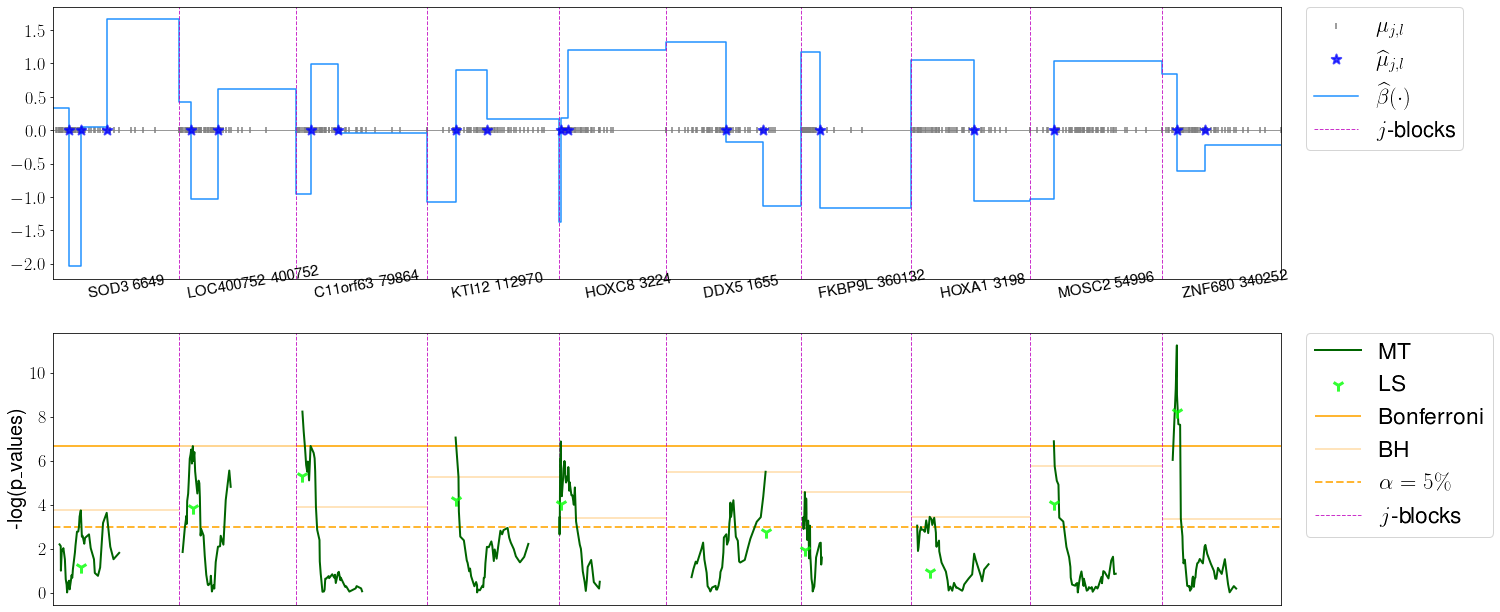




Run on KIRC...
Done binarizing KIRC in 4.40e-02 seconds.

Done estimating with multiple_testing method in 2.40e+02 seconds.

Done Lausen & Schumacher correction in 3.41e-01 seconds.

KIRC estimated cutpoints values for top-10 features:
+---------------+--------------------+-----------------------+--------------------------------+
|      Gene     | Cut-points Binacox | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+---------------+--------------------+-----------------------+--------------------------------+
|   MARS|4141   |  1196.21, 1350.00  |        1350.00        |            1350.00             |
|  STRADA|92335 |   495.24, 553.73   |         586.88        |             586.88             |
|   PTPRH|5794  |        3.32        |          3.32         |              3.32              |
| EIF4EBP2|1979 |      6504.80       |        5455.59        |            5455.59             |
|  RGS17|26575  |        4.30        |          4.30         |              4.30         

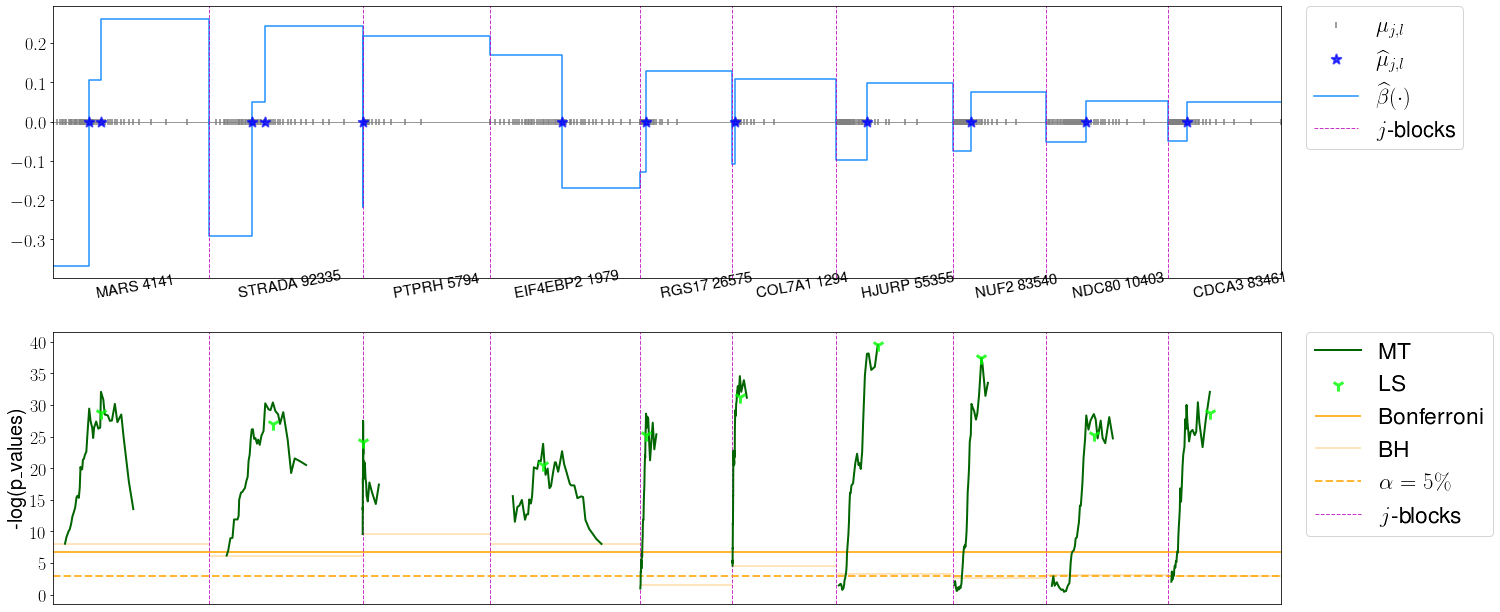




Run on BRCA...
Done binarizing BRCA in 6.33e-02 seconds.

Done estimating with multiple_testing method in 1.29e+02 seconds.

Done Lausen & Schumacher correction in 3.57e-01 seconds.

BRCA estimated cutpoints values for top-10 features:
+----------------+-------------------------------+-----------------------+--------------------------------+
|      Gene      |       Cut-points Binacox      | Cut-points Bonferroni | Cut-points Lausen & Schumacher |
+----------------+-------------------------------+-----------------------+--------------------------------+
|  NPRL2|10641   |         330.64, 568.06        |         330.64        |             330.64             |
|   PLCH2|9651   | 28.43, 200.74, 273.04, 382.87 |         382.87        |             382.87             |
|  HBS1L|10767   |   1023.91, 1212.54, 1782.77   |        1782.77        |            1782.77             |
|  FGD4|121512   |         163.59, 309.24        |         517.90        |             517.90             |
|   M

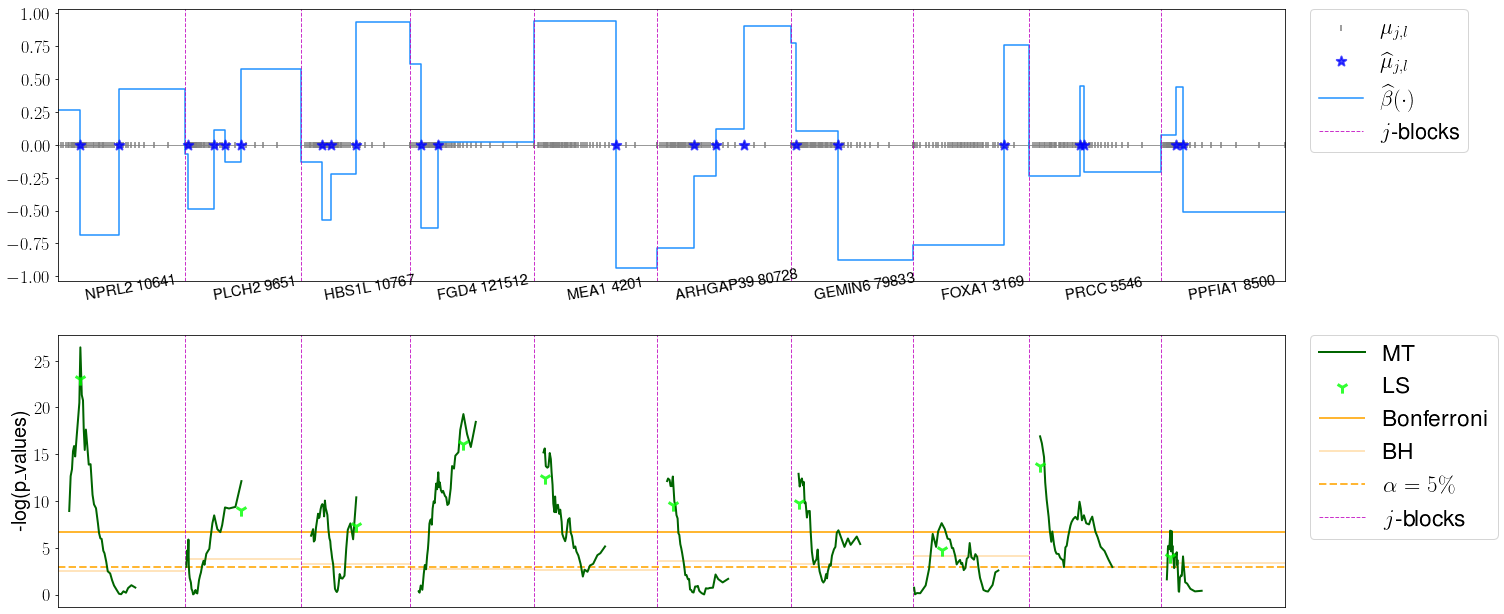

In [5]:
plot_top_k = 10
cancers = ["GBM", "KIRC", "BRCA"]
columns_time = ["cancer", "method", "time"]
time_data = pd.DataFrame(columns=columns_time)
for cancer in cancers:
    print("Run on %s..." % cancer)
    X = data[cancer]["X"]
    Y = data[cancer]["Y"]
    delta = data[cancer]["delta"]
    features_selected = data[cancer]["features_selected"]
    n_samples, n_features = X.shape
    
    # Binarize features
    tic = time()
    n_cuts = 50
    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    X_bin = binarizer.fit_transform(X)
    tac = time()
    print("Done binarizing %s in %.2e seconds." % (cancer, (tac - tic)))
    blocks_start = binarizer.blocks_start
    blocks_length = binarizer.blocks_length
    boundaries = binarizer.boundaries
    
    # Multiple testing method
    tic = time()
    epsilon=10
    multiple_testing_rslt = multiple_testing(X, boundaries, Y, delta, epsilon=epsilon,
                                   features_names=features_selected)
    tac = time()
    MT_1 = tac - tic
    print("\nDone estimating with multiple_testing method in %.2e seconds." % MT_1)
    
    # Lausen & Schumacher correction
    tic = time()
    p_values_corr = []
    X_ = np.array(X)
    for j in range(n_features):
        p_values_j = multiple_testing_rslt[j]
        p_values_corr.append(p_value_cut(p_values_j.p_values, p_values_j.values_to_test, 
                                         X_[:, j], epsilon=epsilon))
    tac = time()
    print("\nDone Lausen & Schumacher correction in %.2e seconds." % (tac - tic))
    time_MT = tac - tic + MT_1
    
    # Get estimated cut-points
    cut_points_estimates_MT_B, cut_points_estimates_MT_LS = {}, {}
    for j in range(n_features):
        p_values_j = multiple_testing_rslt[j]    
        p_values_j_min = p_values_j.p_values.min()
        p_values_j_argmin = p_values_j.p_values.argmin()
        cut_pts_j = p_values_j.values_to_test[p_values_j_argmin]
        
        alpha = .05
        # Bonferroni detection
        n_tested = len(p_values_j.values_to_test)
        est_j = [-np.inf, np.inf]
        if p_values_j_min < alpha / n_tested:
            est_j.insert(1, cut_pts_j)
        cut_points_estimates_MT_B[X.columns[j]] = np.array(est_j)
            
        # Lausen & Schumacher detection
        est_j = [-np.inf, np.inf]
        if p_values_corr[j] < alpha:
            est_j.insert(1, cut_pts_j)
        cut_points_estimates_MT_LS[X.columns[j]] = np.array(est_j)
          
    # Binacox
    tic = time()
    solver = 'agd'
    C_chosen = {"GBM":17, "KIRC":5, "BRCA":15.7}
    learner = CoxRegression(penalty='binarsity', tol=1e-5,
                            solver=solver, verbose=False, 
                            max_iter=100, step=0.3,
                            blocks_start=blocks_start,
                            blocks_length=blocks_length,
                            C=C_chosen[cancer], warm_start=True)
    learner._solver_obj.linesearch = False
    learner.fit(X_bin, Y, delta)
    coeffs = learner.coeffs
    all_groups = list()
    cut_points_estimates = {}
    b_star = np.zeros(len(coeffs))
    for j, start in enumerate(blocks_start):
        coeffs_j = coeffs[start:start + blocks_length[j]]
        all_zeros = not np.any(coeffs_j)
        if all_zeros:
            cut_points_estimate_j = np.array([-np.inf, np.inf])
            groups_j = blocks_length[j] * [0]
        else:
            groups_j = get_groups(coeffs_j)        
            jumps_j = np.where(groups_j[1:] - groups_j[:-1] != 0)[0] + 1

            if len(jumps_j) == 0:
                cut_points_estimate_j = np.array([-np.inf, np.inf])
            else:
                cut_points_estimate_j = boundaries[X.columns[j]][jumps_j]
                if cut_points_estimate_j[0] != -np.inf:
                    cut_points_estimate_j = np.insert(cut_points_estimate_j, 0,
                                                    -np.inf)
                if cut_points_estimate_j[-1] != np.inf:
                    cut_points_estimate_j = np.append(cut_points_estimate_j,
                                                    np.inf)
        cut_points_estimates[X.columns[j]] = cut_points_estimate_j   
        if j > 0:
            groups_j += np.max(all_groups) + 1
        all_groups += list(groups_j)
    binarizer = FeaturesBinarizer(method='given',
                                  bins_boundaries=cut_points_estimates)
    X_bin = binarizer.fit_transform(X)
    blocks_start_ = binarizer.blocks_start
    blocks_length_ = binarizer.blocks_length
    learner = CoxRegression(penalty='binarsity', tol=1e-5,
                            solver=solver, verbose=False,
                            max_iter=100, step=0.3,
                            blocks_start=blocks_start_,
                            blocks_length=blocks_length_,
                            warm_start=True, C=1e10)
    learner._solver_obj.linesearch = False
    learner.fit(X_bin, Y, delta)
    final_coeffs = learner.coeffs
    tac = time()
    
    # Save computing times
    time_data = time_data.append(pd.Series([cancer, "Binacox", tac - tic], index=columns_time), 
                                 ignore_index=True)
    
    # Add computing times for CoxBoost and RSF
    %R -i X,Y,delta
    %R library(CoxBoost)
    tic = time()
    %R cbfit <- CoxBoost(Y, delta, as.matrix(X), stepno=500, penalty=100)
    tac = time()
    time_data = time_data.append(pd.Series([cancer, "CoxBoost", tac - tic], index=columns_time), 
                                 ignore_index=True)
    
    %R library(randomForestSRC)
    tic = time()
    %R data_train <- as.data.frame(X)
    %R data_train["time"] <- Y
    %R data_train["status"] <- delta
    %R rsf <- rfsrc(Surv(time, status) ~ ., data=data_train, ntree=500)
    tac = time()
    time_data = time_data.append(pd.Series([cancer, "RSF", tac - tic], index=columns_time), 
                                 ignore_index=True)
    time_data = time_data.append(pd.Series([cancer, "MT", time_MT], index=columns_time), 
                                 ignore_index=True)
    
    # Get final vectors
    right_translations, block_separation = [], []
    b_star_x, b_star_y = [], []
    hat_beta_star = {}
    hat_beta_star_x, hat_beta_star_y = [], []
    K_star, hat_K_star = np.array([]), np.array([])
    previous_max, start, start_ = 0, 0, 0
    mu, mu_star, hat_mu_star = np.array([]), np.array([]), np.array([])

    # Compute final TV norm per feature    
    hat_beta_star_tv = pd.Series()
    prox_tv = ProxTV(1)
    for j in range(n_features):
        hat_mu_star_j = cut_points_estimates[features_selected[j]][1:-1]
        hat_K_star_j = len(hat_mu_star_j)
        hat_beta_star_j = final_coeffs[start_:start_ + hat_K_star_j + 1]
        hat_beta_star[features_selected[j]] = hat_beta_star_j
        hat_beta_star_tv[features_selected[j]] = [prox_tv.value(hat_beta_star_j)]
        start_ += hat_K_star_j + 1

    hat_beta_star_tv.sort_values(ascending=False, inplace=True)
    feature_names_to_plot = hat_beta_star_tv.index[:plot_top_k]
    for j, feature_name_j in enumerate(feature_names_to_plot):
        mu_jk = boundaries[feature_name_j].copy()[1:-1]    
        current_min = np.min(mu_jk)
        right_translation = previous_max
        if(j > 0):
            right_translation += abs(current_min)
        right_translations += [right_translation]
        mu_jk += right_translation
        mu = np.append(mu, mu_jk)
        hat_mu_star_j = cut_points_estimates[feature_name_j][1:-1] + right_translation
        hat_mu_star = np.append(hat_mu_star, hat_mu_star_j)
        hat_K_star_j = len(hat_mu_star_j)
        hat_K_star = np.append(hat_K_star, hat_K_star_j)
        hat_beta_star_j = hat_beta_star[feature_name_j]
        hat_beta_star_x += [current_min if j==0 else previous_max]
        hat_beta_star_y += [hat_beta_star_j[0]]
        for k in range(hat_K_star_j):
            hat_l_jk = np.argmax(np.where(mu_jk <= hat_mu_star_j[k]))
            hat_beta_star_x += [mu_jk[hat_l_jk]]
            hat_beta_star_y += [hat_beta_star_j[k + 1]]
        previous_max = np.max(mu)
        block_separation += [previous_max]
    hat_beta_star_x += [previous_max]
    hat_beta_star_y = [hat_beta_star_y[0]] + hat_beta_star_y
    
    # Visualization
    fig = pl.figure(figsize=(22, 11))
    ax = fig.add_subplot(211)
    ax.axhline(0, c='grey', alpha=.8, lw=1)
    pl.step(hat_beta_star_x, hat_beta_star_y, c='dodgerblue', 
            label=r"$\widehat\beta(\cdot)$")
    pl.scatter(hat_mu_star, np.zeros(len(hat_mu_star)), c='b', marker='*',
               s=100, lw=2, label=r"$\widehat\mu_{j,l}$", zorder=6, alpha=.7)
    pl.scatter(mu, np.zeros(len(mu)), c='grey', marker="|",
              label=r"$\mu_{j,l}$")
    pl.tick_params(axis='x', which='both', bottom=False,
                   top=False, labelbottom=False)
    pl.yticks(fontsize = 18)
    y_min, y_max = ax.get_ylim()
    ax.set_xlim([mu[0], mu[-1]])
    
    previous_separation = mu[0]
    for j in range(plot_top_k):
        label = ''
        if j == 0:
            label = r'$j$-blocks'
        ax.axvline(block_separation[j], c='m', ls='--', 
                   alpha=.8, lw=1, label=label)
        
        # Plot features names
        feature_names_to_plot_j = feature_names_to_plot[j].replace("|", " ")
        feature_names_to_plot_j = feature_names_to_plot_j.split(" 100270710")[0]
        coeff = .30 - (len(feature_names_to_plot_j) - 8) / 35
        if feature_names_to_plot_j == "PITPNA 5306":
            coeff = .32
        rotation = 10            
        ax.text(previous_separation + coeff * (block_separation[j] - previous_separation), 
                y_min - .07 * (y_max - y_min), feature_names_to_plot_j, rotation=rotation,
                fontsize=15)
        previous_separation = block_separation[j]
        
    h, l = ax.get_legend_handles_labels()
    h = [h[3], h[2], h[0], h[1]]
    l = [l[3], l[2], l[0], l[1]]
    ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), 
              loc=2, borderaxespad=0, fontsize=22)
    
    ax = fig.add_subplot(212)
    ax.set_xlim([mu[0], mu[-1]])
    pl.tick_params(axis='x', which='both', bottom=False,
                   top=False, labelbottom=False)
    pl.yticks(fontsize = 18)
    pl.ylabel("-log(p\_values)", fontsize=20)
    
    idx_feature_names_to_plot = [list(features_selected).index(feature_name) 
                                 for feature_name in feature_names_to_plot]
    scaler = data[cancer]["scaler"]
    t = PrettyTable(['Gene', 'Cut-points Binacox', 'Cut-points Bonferroni',
                     'Cut-points Lausen & Schumacher'])
    for k, j in enumerate(idx_feature_names_to_plot):
        mean_j = scaler.mean_[j]
        scale_j = scaler.scale_[j]
        est_orig_binacox_j = ""
        for cut_pts in cut_points_estimates[feature_names_to_plot[k]][1:-1]:
            cut_points_orig = cut_pts * scale_j + mean_j
            if est_orig_binacox_j != "":
                est_orig_binacox_j += ", "
            est_orig_binacox_j += "%.2f" % cut_points_orig
        
        est_orig_MT_B_j = "None"
        est_MT_B_j = cut_points_estimates_MT_B[feature_names_to_plot[k]][1] 
        if est_MT_B_j != np.inf:
            est_orig_MT_B_j = "%.2f" % (est_MT_B_j * scale_j + mean_j)
        
        est_orig_MT_LS_j = "None"
        est_MT_LS_j = cut_points_estimates_MT_LS[feature_names_to_plot[k]][1] 
        if est_MT_LS_j != np.inf:
            est_orig_MT_LS_j = "%.2f" % (est_MT_LS_j * scale_j + mean_j)
        
        t.add_row([feature_names_to_plot[k], est_orig_binacox_j,
                   est_orig_MT_B_j, est_orig_MT_LS_j])
        
        p_values_j = multiple_testing_rslt[j]
        label = ''
        if k == 0:
            label = "MT"
        ax.plot(p_values_j.values_to_test + right_translations[k], 
                -np.log(p_values_j.p_values), c='darkgreen', label=label, lw=2, zorder=3)  
        if k == 0:
            label = "LS"
        arg_min = p_values_j.values_to_test[p_values_j.p_values.argmin()]
        pl.scatter(arg_min + right_translations[k], -np.log(p_values_corr[j]) , c='lime', 
                   marker='1', s=150, lw=3, label=label, zorder=4, alpha=.8)
        if k == 0:
            label = r'$j$-blocks'
        ax.axvline(block_separation[k], c='m', ls='--', 
                   alpha=.8, lw=1, label=label)
        
    _, y_max = ax.get_ylim()
    for k, j in enumerate(idx_feature_names_to_plot):
        p_values_j = multiple_testing_rslt[j]
        label = ""        
        if k == 0:
            label = "Bonferroni"
            min_val = mu[0]
        else:
            min_val = block_separation[k - 1]
        n_tested = p_values_j.values_to_test.shape[0]
        pl.hlines(-np.log(.05/n_tested), min_val, block_separation[k], 
                  colors='orange', linestyles='-', alpha=.8, lw=2, label=label)
        
        label = ""
        if k == 0:
            label = "BH"    
        FDR = .05
        for i, p_val in enumerate(np.sort(p_values_j.p_values)):
            BH_threshold = p_val
            if p_val > (i + 1) * FDR / n_tested:
                break
        pl.hlines(-np.log(BH_threshold), min_val, block_separation[k], 
                  colors='navajowhite', linestyles='-', alpha=.8, lw=2, label=label)
        
    ax.axhline(-np.log(.05), c='orange', ls='--', 
               alpha=.8, lw=2, label=r'$\alpha=5\%$')
    
    h, l = ax.get_legend_handles_labels()
    h = [h[0], h[3], h[4], h[5], h[2], h[1]]
    l = [l[0], l[3], l[4], l[5], l[2], l[1]]
    ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), loc=2, 
              borderaxespad=0, fontsize=23)
    
    pl.savefig('./figures/%s.pdf' % cancer, bbox_inches='tight')
    print("\n%s estimated cutpoints values for top-%s features:" % (cancer, plot_top_k))
    print(t)
    pl.show()
    print("\n\n")

## Computing time comparison

<Figure size 720x504 with 0 Axes>

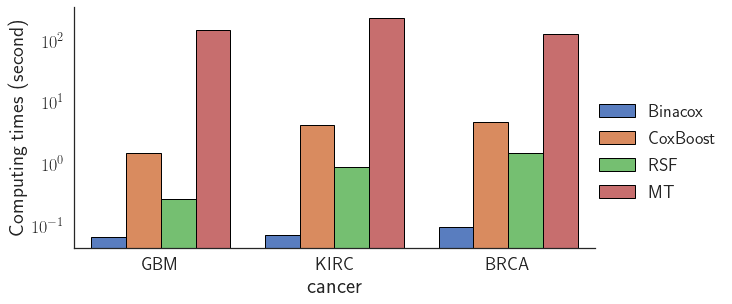

In [6]:
import seaborn.apionly as sns 

fig = pl.figure(figsize=(10, 7))
sns.set(style="white")
g = sns.factorplot(x="cancer", 
                   y="time", 
                   hue="method", 
                   data=time_data,
                   aspect=2,
                   size=4,
                   kind="bar",
                   edgecolor='black',
                   palette="muted",
                   legend=False)
g.set_ylabels(r"Computing times (second)", fontsize=21)
g.set_xlabels("cancer", fontsize=22)
g.set_xticklabels(fontsize = 18)
g.set_yticklabels(fontsize = 18)
g.fig.get_axes()[0].set_yscale('log')
g.add_legend(fontsize = 18)
pl.savefig('./figures/time_tcga.pdf', bbox_inches='tight')
pl.show()